In [1]:
#storing and manipulating data
import pandas as pd
import numpy as np

#plotting
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

#natural language tool kit
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#RoBERTa Model from Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax

## Load / Data Wrangling for Sentiment Analysis

In [2]:
data = pd.read_csv('Reviews.csv', usecols=['Score', 'Summary', 'Text'])
print(data.shape)
display(data.head())

(568454, 3)


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


**Sampling Approach**

In [3]:
#the overall dataset is too large so we will downsample the data to 500 examples for analysis 
sample_data = data.sample(500)

#combine the summary / heading and text description
sample_data['review_text'] = sample_data['Summary'] + ' ' +  sample_data['Text']

#we can also remove the previous original columns
sample_data.drop(['Summary', 'Text'], axis = 1, inplace = True)
    
sample_data = sample_data.reset_index()
sample_data.drop(['index'], axis = 1, inplace=True)
sample_data.head()

,Score,review_text
0,5,I LOVE this stuff I eat at least one bowl of t...
1,5,Tasty We keep a box of these in our supply bin...
2,5,Newman's Own My cat eats well and has good dig...
3,5,A deliciously potent peppermint tea! This stuf...
4,5,Good vanilla flavor ... Sugar free Torani vani...


In [4]:
# Let's use a previews sample obtained
df = pd.read_csv('amazon_reviews_dataset_500.csv')
df.head()

,Score,review_text
0,1,Sprayed orange grease all over the inside of t...
1,3,Had higher expectations It is a naturally swee...
2,5,Everything is as it should be I ordered these ...
3,5,So Happy I found this; Product is Fabulous I d...
4,5,"Great tea, very satisfying Nice mellow tea for..."


## Exploratory Data Analysis (EDA)

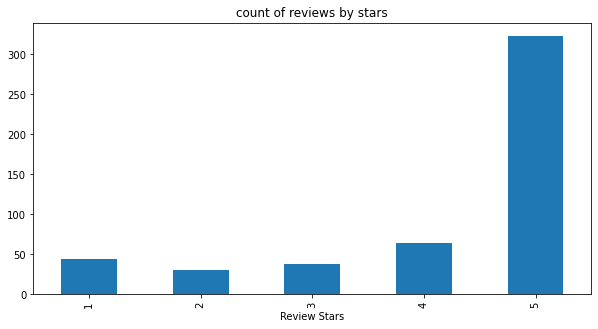

In [5]:
fig, ax = plt.subplots(figsize = (10, 5))
ax = df['Score'].value_counts().sort_index().plot(kind = 'bar')
ax.set_xlabel('Review Stars')
plt.title('count of reviews by stars')
plt.show()

The overall distribution of reviews seems to be more positive and then there is a slight spike in the 1 star negetive reviews, so data is mostly very polar.

## Basic NLTK

In [6]:
example = df['review_text'][50]
print(example)

Great Price, Not what I was hoping for though. There's the original Tang. There's the fruition Tang that was around from 2008 to 2010, which had extra vitamins (B,D,A, etc.) and replaced half the sugar with zero calorie sweeteners. But tang has gone back to a flavor more similar to the original with full sugar content. I was hoping for the fruition version, which other reviewers received.


In [7]:
#use the nltk's word tokenizer to smartly split the sentence into tokens which can be used to understand the language by the computer
tokens = nltk.word_tokenize(example)
tokens[:8]

['Great', 'Price', ',', 'Not', 'what', 'I', 'was', 'hoping']

In [8]:
#find the part of speech for each of the token words with nltk each word will get a part of speech value associated with them 
#and they are represented with codes like NN is for singular nouns
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('Great', 'NNP'),
 ('Price', 'NNP'),
 (',', ','),
 ('Not', 'RB'),
 ('what', 'WP'),
 ('I', 'PRP'),
 ('was', 'VBD'),
 ('hoping', 'VBG'),
 ('for', 'IN'),
 ('though', 'IN')]

In [9]:
#we can group these tagged values into chunks of tags entities
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  (GPE Great/NNP)
  Price/NNP
  ,/,
  Not/RB
  what/WP
  I/PRP
  was/VBD
  hoping/VBG
  for/IN
  though/IN
  ./.
  There/EX
  's/VBZ
  the/DT
  original/JJ
  (PERSON Tang/NNP)
  ./.
  There/EX
  's/VBZ
  the/DT
  fruition/NN
  (PERSON Tang/NNP)
  that/WDT
  was/VBD
  around/IN
  from/IN
  2008/CD
  to/TO
  2010/CD
  ,/,
  which/WDT
  had/VBD
  extra/JJ
  vitamins/NNS
  (/(
  B/NNP
  ,/,
  (GPE D/NNP)
  ,/,
  A/NNP
  ,/,
  etc/FW
  ./.
  )/)
  and/CC
  replaced/VBD
  half/PDT
  the/DT
  sugar/NN
  with/IN
  zero/CD
  calorie/NN
  sweeteners/NNS
  ./.
  But/CC
  tang/NN
  has/VBZ
  gone/VBN
  back/RB
  to/TO
  a/DT
  flavor/NN
  more/JJR
  similar/JJ
  to/TO
  the/DT
  original/JJ
  with/IN
  full/JJ
  sugar/NN
  content/NN
  ./.
  I/PRP
  was/VBD
  hoping/VBG
  for/IN
  the/DT
  fruition/NN
  version/NN
  ,/,
  which/WDT
  other/JJ
  reviewers/NNS
  received/VBD
  ./.)


## VADER Sentiment Scoring

**VADER**: Valence Aware Dictonary and sEntiment Reasoner

We'll use NLTK's `SentimentInetensityAnalyzer` to get the negetive (neg), neutral (neu) and positive (pos) scores for the text.

**Approach**:
- Uses a "bag of words" approach
- Stop words are removed - words like (is, the, am, etc.)
- each word is scored and combined to a total score to get a overall sentiment score of text.

**Limitations**:
- does not account for relationships between words, which is an important part of human speech.

In [10]:
sia = SentimentIntensityAnalyzer()

In [11]:
#example of using sentiment analyzer on a positive sentence
sia.polarity_scores('I am so happy! Today is such a great day and I love ML.')

{'neg': 0.0, 'neu': 0.389, 'pos': 0.611, 'compound': 0.9272}

In [12]:
#on the other hand sentiment analyzer on a negetive example
sia.polarity_scores('This is the worst thing ever, I would never buy something this bad.')

{'neg': 0.451, 'neu': 0.549, 'pos': 0.0, 'compound': -0.8491}

In [13]:
#It can also work well on some confusing sentences - to give a overall slightly positive rating for this sentence.
sia.polarity_scores('hey, I hate you, just kidding you know I love you!')

{'neg': 0.237, 'neu': 0.385, 'pos': 0.378, 'compound': 0.2942}

**Observations**:

We are successfully able to identify the overall sentiment of the text with compound score which varies between 1 (for positive) and -1 (for negetive).

Now we can try to apply this to our reviews dataset.

In [14]:
#Run Polarity Score on the entire dataset
res = {}
for idx, row in df.iterrows():
    text = row['review_text']
    res[idx] = sia.polarity_scores(text)

In [15]:
vaders = pd.DataFrame(res).T
vaders = vaders.merge(df, how = 'left', right_index=True, left_index=True)
vaders.head()

,neg,neu,pos,compound,Score,review_text
0,0.070,0.800,0.130,0.8422,1,Sprayed orange grease all over the inside of t...
1,0.082,0.727,0.192,0.7655,3,Had higher expectations It is a naturally swee...
2,0.025,0.807,0.168,0.9238,5,Everything is as it should be I ordered these ...
3,0.092,0.693,0.214,0.9061,5,So Happy I found this; Product is Fabulous I d...
4,0.000,0.497,0.503,0.9692,5,"Great tea, very satisfying Nice mellow tea for..."


**How to measure effectiveness?**

One way to see if our model is working as expected or not, is to check an assumption.

We can assume that what our model classifies as more positive has higher star review and the reviews predicted to be more negetive have a lower star review associated with them.

If this is true then, we can rely on text sentiment analysis to tell us how our users feel about products overall.

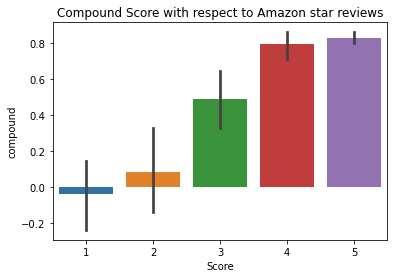

In [16]:
# Plot Vaders results
sns.barplot(data=vaders, x='Score', y='compound')
plt.title('Compound Score with respect to Amazon star reviews')
plt.show()

**Observation:** We can see that the assumptions seems to be right as higher star reviews have a high compound score associated with them.

**Taking a look at each component of sentiment analysis (pos, neu and neg) with respect to star reviews**

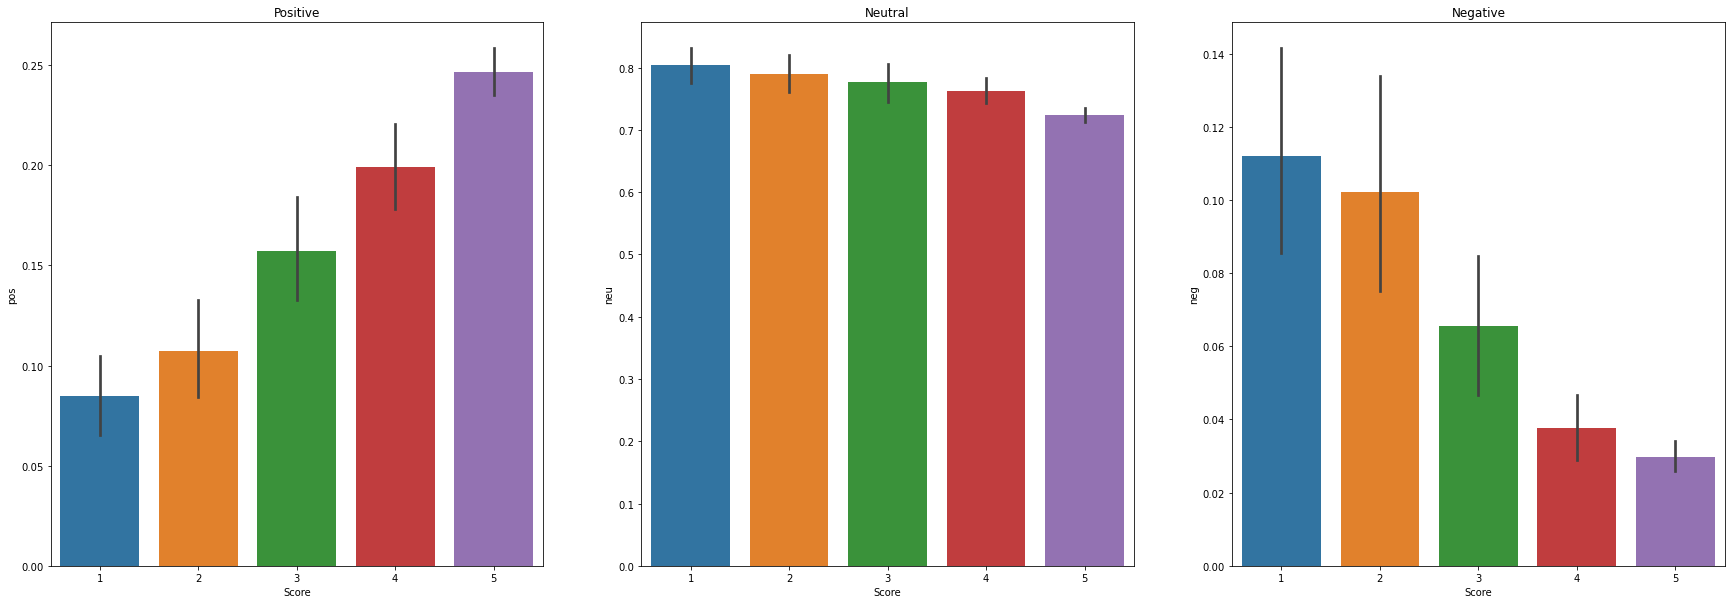

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

**Observations:**
- postivity score is higher as star reviews are higher star reviews
- neural scores do not vary much accross different star reviews
- negativity score decreases with higher star reviews

**So we can conclude that our sentiment analysis score does relate to the star reviews given by the users**

**Limitations**

This way of analyzing text with vader does not consider the relationship between the words and the context in which they are used, so we can improve upon that using the state of the art Transformer based BERT models which can understand and learn context and make better prediction of overall sentiment.

## RoBERTa Pretrained Model

- Use a model trained on large corpus of data (with hundred Millions+ examples)
- Transformer model accounts for the words bit also their context related to other words.
    - like for sentences which have negative words in it but it actually is just sarcastic.
    - or ironic sentences with positive words but overall negative sentiment.

We are essentially using transfer learning by using pretrained weights of a model created for analyzing the sentiments of tweets to perform review sentiment analysis.

In [19]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

model_name = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

**Comparing models performence over example review**

In [20]:
#VADER Results on example
print(example)
sia.polarity_scores(example)

Great Price, Not what I was hoping for though. There's the original Tang. There's the fruition Tang that was around from 2008 to 2010, which had extra vitamins (B,D,A, etc.) and replaced half the sugar with zero calorie sweeteners. But tang has gone back to a flavor more similar to the original with full sugar content. I was hoping for the fruition version, which other reviewers received.


{'neg': 0.064, 'neu': 0.815, 'pos': 0.12, 'compound': 0.6169}

In [21]:
#Run Roberta model for example
#here tf = tensorflow
encoded_text = tokenizer(example, return_tensors='pt') 
encoded_text

{'input_ids': tensor([[    0, 19065,  3655,     6,  1491,    99,    38,    21,  2818,    13,
           600,     4,   345,    18,     5,  1461, 20749,     4,   345,    18,
             5, 25789, 20749,    14,    21,   198,    31,  2266,     7,  1824,
             6,    61,    56,  1823, 26656,    36,   387,     6,   495,     6,
           250,     6,  4753,  1592,     8,  4209,   457,     5,  4696,    19,
          4276, 30648,  4045, 31469,     4,   125, 25044,    34,  1613,   124,
             7,    10, 12117,    55,  1122,     7,     5,  1461,    19,   455,
          4696,  1383,     4,    38,    21,  2818,    13,     5, 25789,  1732,
             6,    61,    97, 34910,   829,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
output = model(**encoded_text)

In [23]:
scores = output[0][0].detach().numpy()
scores = softmax(scores) 
scores_dict = {
    'roberta_pos': scores[0],
    'roberta_neu': scores[1],
    'roberta_neg': scores[2],
}
scores_dict

{'roberta_pos': 0.09246168, 'roberta_neu': 0.5420258, 'roberta_neg': 0.3655125}

In [25]:
print(f"User's actual given star review on the example is: {df['Score'][50]}")

User's actual given star review on the example is: 4


**Observation:**

The Roberta Model does seem to better understand the context and give a overall more appropriate score for the given example, that the user does start with a positive comment but actually have some complaints about the products too. But as we can confirm from user's given rating the overall sentiment and review is still positive.

**Run the RoBERTa model over all the review examples**

In [26]:
def polarity_scores_roberta(text):
    encoded_text = tokenizer(text, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2],
    }
    
    return scores_dict

In [39]:
results = {}
for idx, row in tqdm(df.iterrows(), total=len(df)):

    text = row['review_text']

    #Roberta Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    vader_result = sia.polarity_scores(text)    
    #rename the results of vader
    vader_result_rename = {}
    for key, value in vader_result.items():
        vader_result_rename[f'vader_{key}'] = value

    #making predictions using roberta model
    roberta_result = polarity_scores_roberta(text)

    #combine both results 
    result = roberta_result.copy()
    result.update(vader_result_rename)

    results[idx] = result

In [40]:
results_df = pd.DataFrame(results).T
results_df = results_df.merge(df, how = 'left', right_index=True, left_index=True)
results_df.head()

,roberta_neg,roberta_neu,roberta_pos,vader_neg,vader_neu,vader_pos,vader_compound,Score,review_text
0,0.655937,0.270591,0.073472,0.064,0.805,0.132,0.7269,1,Sprayed orange grease all over the inside of t...
1,0.555764,0.328938,0.115297,0.082,0.727,0.192,0.7655,3,Had higher expectations It is a naturally swee...
2,0.002329,0.030420,0.967251,0.025,0.807,0.168,0.9194,5,Everything is as it should be I ordered these ...
3,0.090271,0.174114,0.735615,0.092,0.693,0.214,0.9061,5,So Happy I found this; Product is Fabulous I d...
4,0.002495,0.013362,0.984142,0.000,0.497,0.503,0.9692,5,"Great tea, very satisfying Nice mellow tea for..."


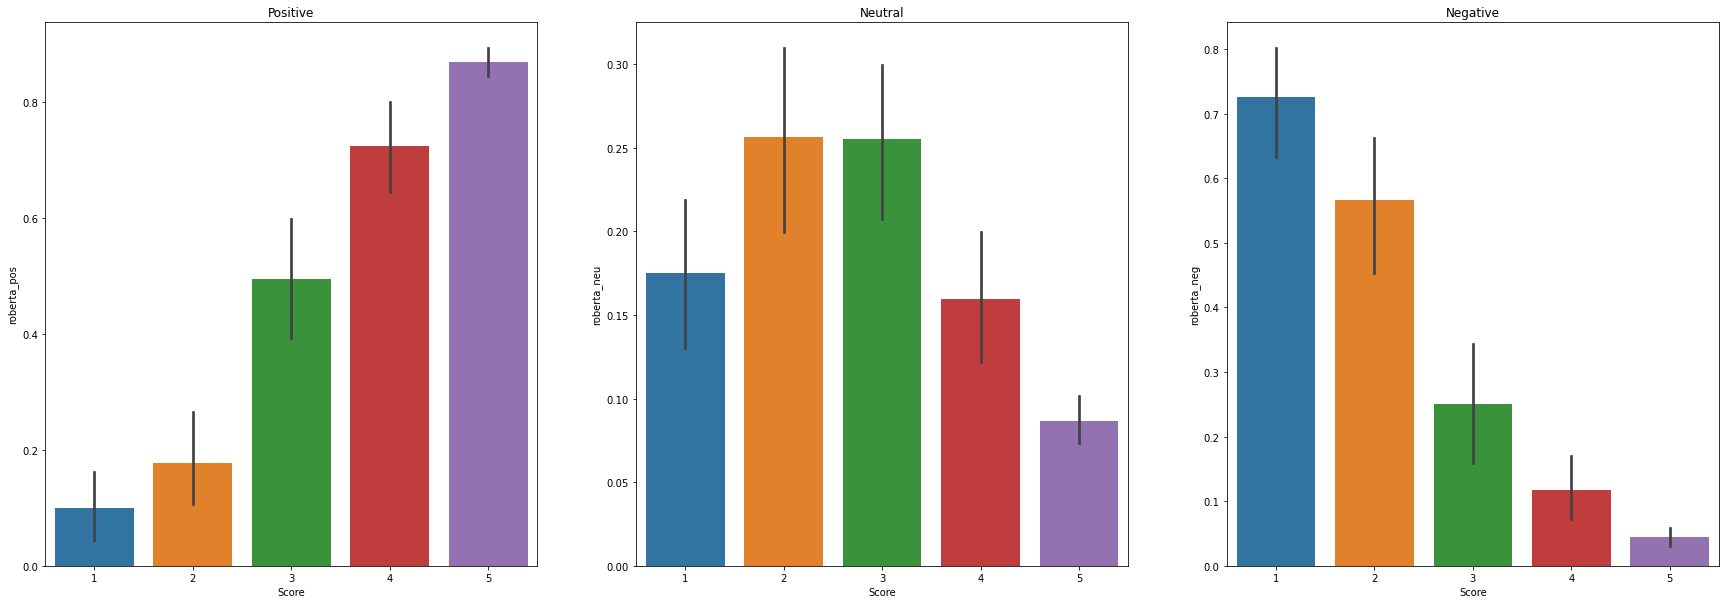

In [41]:
# Plot Roberta results
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
sns.barplot(data=results_df, x='Score', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='Score', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='Score', y='roberta_neg', ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.show()

**Observations:**
- with roberta model there seems to be a even more clear trend as when positivity score increases the star rating increases and with higher star reviews negetive sentiment decreases drastically. So we can get a much better idea of how users are feeling with text sentiment prediction by Roberta Model.

## Review Examples

**Positive Sentiment Prediction but low star review**

Which are the examples that our models classifies as having a positive sentiment but it actually has a low star rating

In [42]:
results_df.query('Score == 1').sort_values('vader_pos', ascending=False)['review_text'].values[0]

"YUCH! Impressed,as always,with Amazon's expedient delivery. I perused customer reviews before ordering and felt comfortable with my choice (I was going to get the Emeril Bourbon Street blend , which I love) as reviewers gave this a great rating. I find it strong but bitter as opposed to strong and rich. Would not recommend this blend to anyone. No negatives to Amazon but wonder who could find this a pleasurable coffee."

- So we can see this is a confusing statement as the user praises Amazon's service but is actually disappointed by the product, and our model was not able to make that distinction.

In [43]:
results_df.query('Score == 1').sort_values('roberta_pos', ascending=False)['review_text'].values[0]

"YUCH! Impressed,as always,with Amazon's expedient delivery. I perused customer reviews before ordering and felt comfortable with my choice (I was going to get the Emeril Bourbon Street blend , which I love) as reviewers gave this a great rating. I find it strong but bitter as opposed to strong and rich. Would not recommend this blend to anyone. No negatives to Amazon but wonder who could find this a pleasurable coffee."

- Roberta model also got the same review wrong

**Negative Sentiment Prediction but high star review**

Which are the examples that our models classifies as having a negative sentiment but it actually has a high star rating.

In [44]:
results_df.query('Score == 5').sort_values('vader_neg', ascending=False)['review_text'].values[0]

"Miss those nuts Really enjoy those Redskins. Realy disappointment that Planters discontinued those big cans. Now I have to buy small ones frequently. Let's get them back."

- The sentence does contain words like disappointment and user does want some changes in product but overall, the user has a positive sentiment towards the product.

In [45]:
results_df.query('Score == 5').sort_values('roberta_neg', ascending=False)['review_text'].values[0]

"price warp Exceptional coffee, but now priced out of my league.  This is the most totally unreasonable price hike I've seen in a long while--anywhere for anything."

- In the text review the user expresses disagreement with change in product price, so our model classified it as a negative sentiment but the user's overall sentiment towards the product is positive.

## Directly predicting the star rating from the text review
Using the `**BERT**` based model from hugging face 🤗 to classify the text between 1 to 5 star rating depending on the sentiment of the comment.

- Instead of just predicting if the review is positive or not, we can get a more quantitative result in form of rating.

In [46]:
#load the model
ratings_model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
ratings_tokenizer = AutoTokenizer.from_pretrained(ratings_model_name)
ratings_model = AutoModelForSequenceClassification.from_pretrained(ratings_model_name)

In [47]:
print("Example review:", example)
print("\nActual Rating:", df['Score'][50])

Example review: Great Price, Not what I was hoping for though. There's the original Tang. There's the fruition Tang that was around from 2008 to 2010, which had extra vitamins (B,D,A, etc.) and replaced half the sugar with zero calorie sweeteners. But tang has gone back to a flavor more similar to the original with full sugar content. I was hoping for the fruition version, which other reviewers received.

Actual Rating: 4


In [48]:
ratings_encoded_text = ratings_tokenizer(example, return_tensors='pt')
ratings_encoded_text

{'input_ids': tensor([[  101, 11838, 16993,   117, 10497, 11523,   151, 10140, 13365, 10285,
         10139, 14325,   119, 10768,   112,   161, 10103, 11383, 14167,   119,
         10768,   112,   161, 10103, 25527, 11210, 14167, 10203, 10140, 12096,
         10195, 10224, 10114, 10183,   117, 10359, 10407, 17708, 44691, 10107,
           113,   144,   117,   146,   117,   143,   117, 12575,   119,   114,
         10110, 16841, 13460, 10103, 25238, 10171, 17209, 43444, 10453, 19355,
         36652, 10107,   119, 10502, 14167, 10438, 23398, 11677, 10114,   143,
         19341, 27553, 10131, 10772, 13344, 10114, 10103, 11383, 10171, 12851,
         25238, 18491,   119,   151, 10140, 13365, 10285, 10139, 10103, 25527,
         11210, 10947,   117, 10359, 10675, 12893, 11122, 12552,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [49]:
ratings_output = ratings_model(**ratings_encoded_text)

In [50]:
ratings_output.logits[0].detach().numpy()

array([-1.4275525,  0.7332723,  1.8107648,  0.8325193, -1.6171392],
      dtype=float32)

In [51]:
#we have to add one as indexing starts from 0 but star ratings are from 1 to 5
ratings_pred = np.argmax(ratings_output.logits[0].detach().numpy()) + 1
print("Predicted Star rating:", ratings_pred)

Predicted Star rating: 3


In [52]:
def rating_prediction_bert(text):
    ratings_encoded_text = ratings_tokenizer(text, return_tensors='pt')
    res = ratings_model(**ratings_encoded_text)
    rating = np.argmax(res.logits[0].detach().numpy()) + 1
    
    return {'rating' : rating}

**Make prediction for all reviews**

In [53]:
ratings_results = {}
for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_text']

    #BERT Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    #making rating predictions using bert model
    rating_prediction = rating_prediction_bert(text)

    ratings_results[idx] = rating_prediction

In [54]:
ratings_df = pd.DataFrame(ratings_results).T
ratings_df = ratings_df.merge(df, how = 'left', right_index=True, left_index=True)
ratings_df.head()

,rating,Score,review_text
0,2,1,Sprayed orange grease all over the inside of t...
1,3,3,Had higher expectations It is a naturally swee...
2,5,5,Everything is as it should be I ordered these ...
3,5,5,So Happy I found this; Product is Fabulous I d...
4,5,5,"Great tea, very satisfying Nice mellow tea for..."


In [55]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(ratings_df['rating'], ratings_df['Score'])
accuracy

0.692

In [56]:
one_off_accuracy = np.where(abs(ratings_df['rating'] - ratings_df['Score']) <= 1, 1, 0).sum() / ratings_df.shape[0]
one_off_accuracy

0.95

- We can exactly predict the rating of review with `~70%` accuracy and can predict the rating very closely (just one more or less) with `95%` accuracy.

- So we can now say that model works considerably well and can be used for understanding the users sentiments over new products and services in the future or we can use it to analyze some other existing products or businesses.

## Using our Models to make predictions on new data scraped from Yelp to perform Sentiment Analysis

Now we will select a restraunt business on Yelp and collect some reviews from the customers to see if this is a place where people like to eat or NOT, we can do a similar thing for any business and collect data from multiple sources also like twitter, reddit, youtube, facebook, instagram and more.

In [57]:
import requests
from bs4 import BeautifulSoup
import re

In [58]:
r = requests.get('https://www.yelp.com/biz/mejico-sydney-2')
soup = BeautifulSoup(r.text, 'html.parser')
regex = re.compile('.*comment.*')
results = soup.find_all('p', {'class': regex})
reviews = [result.text for result in results]

In [59]:
reviews[:2]

["Seated without a booking on a super busy Saturday night. Lovely, warm, and Theo right hostess also looked after our table and went out of her way to give detailed ingredients in every dish to avoid allergies for one of us. And the food was great! Guacamole made right at our table, everything prepared with our allergies in mind, and great dish recommendations. We'd been visiting Sydney for about a week from Melbourne, and this was by far our best dining experience. I'd definitely return here in the future.",
 'The food was decent not great..  We had the guacamole which was bland and came with some type of plantain chips.. The chicken and steak tacos were good.. But the service was poor. We had a waitress with an attitude. She seemed upset whenever we asked for anything.  She would walk by and just stick up her hand and say " just wait ".  She spilled the ingredients to make the guacamole all over the table but never apologized. The waitress didn\'t come by at all, not even once to che

In [60]:
#store reviews in a dataframe
yelp_reviews = pd.DataFrame(np.array(reviews), columns=['review_text'])
yelp_reviews.head()

,review_text
0,Seated without a booking on a super busy Satur...
1,The food was decent not great.. We had the gu...
2,"Food was okay, guacamole was below average. Se..."
3,The food and service here was really good. It...
4,Visiting from Texas and decided to give this r...


In [62]:
#Now we can make perform some sentiment analysis over these text reviews
#using RoBERTa model to get different component scores (pos, neu and neg)
#and BERT to predict numerical star ratings
yelp_results = {}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_text']

    #Roberta Model can only accept text with max length of 514
    if len(text) > 514:
        text = text[:514]

    #making predictions using roberta model
    roberta_result = polarity_scores_roberta(text)
    
    #making star prediction using bert model
    bert_result = rating_prediction_bert(text)
    #combine both results 
    result = roberta_result.copy() 
    result.update(bert_result)
    
    yelp_results[idx] = result   

In [63]:
yelp_results_df = pd.DataFrame(yelp_results).T
yelp_results_df = yelp_results_df.merge(yelp_reviews, how = 'left', right_index=True, left_index=True)
yelp_results_df.head()

,roberta_neg,roberta_neu,roberta_pos,rating,review_text
0,0.655937,0.270591,0.073472,2.0,Seated without a booking on a super busy Satur...
1,0.555764,0.328938,0.115297,3.0,The food was decent not great.. We had the gu...
2,0.002329,0.030420,0.967251,5.0,"Food was okay, guacamole was below average. Se..."
3,0.090271,0.174114,0.735615,5.0,The food and service here was really good. It...
4,0.002495,0.013362,0.984142,5.0,Visiting from Texas and decided to give this r...


In [64]:
yelp_results_df.rating.mean()

4.026

## Conclusion:

So using text reviews we predicted that the restraunt has overall rating of approximatly 4, and we can confirm that our model can give us a good idea about sentiment towards any business with just the text reviews because the actual rating of the restraunt is 4.5 and we were able to closely predict that with just a small sample of reviews and this can get better by analyzing all the reviews.

## How is all of this useful?

We can use hundereds of thousands of online comments and text reviews posted by people on social media about any particular product, movie, service, business or Ad campaign to understand the overall feeling of public towards that. We can use this to better select and market our products and make data driven decisions.

This can help us deliver better services and increase profit margins among other things.

## Function for making predictions

In [67]:
#function to perform sentiment analysis for any given text and also predict the numerical rating out of 5
def predict_sentiment_and_rating(text):
    #making sentiment predictions using roberta model (positive, neutral and negative)
    roberta_result = polarity_scores_roberta(text)
    
    #making star prediction using bert model (stars / score out of 5)
    bert_result = rating_prediction_bert(text)
    
    #combine both results 
    result = roberta_result.copy()
    result.update(bert_result)
    
    return result

In [68]:
predict_sentiment_and_rating("Oh I love this place this is the most amazing thing ever. It great every time I go there.")

{'roberta_neg': 0.0026398143,
 'roberta_neu': 0.004872264,
 'roberta_pos': 0.9924879,
 'rating': 5}

In [69]:
predict_sentiment_and_rating("No I am not a fan of this, not recommended at all.")

{'roberta_neg': 0.970489,
 'roberta_neu': 0.026750673,
 'roberta_pos': 0.0027602962,
 'rating': 1}

**We can use this function in future to make predictions on any reviews to analyze the sentiment of the user and learn thier opinion quantitatively**

It can also be used to deploy a simple web app that works for a single review at a time or a batch of reviews together